# Numerics 1: Homework 8

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## a)
Here we write a program to solve the B-splines problem

In [109]:
'''
bSpline: Returns the piecewise aspect of the B-spline

Input:
    mod: i modifier (i.e. i-1, i+0, i+1, i+2) for the B-spline
    t: The data location
    x: (x_i, x_i+1) the interval t lives in
    
Output:
    The B-spline with modifier mod evaluated at t
'''
def bSpline(mod, t, x):
    h = x[1]-x[0]
    
    if mod == -1:
        return ((x[1]-t)**3)/h**3
    
    elif mod == 0:
        return (h**3 + 3*(x[1]-t)*h**2 + 3*h*(x[1]-t)**2 - \
                3*(x[1]-t)**3)/h**3
    
    elif mod == 1:
        return (h**3 + 3*(t-x[0])*h**2 + 3*h*(t-x[0])**2 - \
                3*(t-x[0])**3)/h**3
    
    elif mod == 2:
        return ((t-x[0])**3)/h**3
    
    else:
        return 0

'''
leastSplines: Constructs a matrix and solves the linear least squares
problem to choose a spline function for the interval [a,b]

Input:
    a: Left hand endpoint
    b: Right hand endpoint
    n: Number of subintervals, needs to be greater than 1
    f: Function handler
    m: Optional, number of data points, if None then m
Output:
    Success: Coefficients (c) for the bsplines and grid points (x),
    optional the matrix (A) in the least squares problem.
    Failure: Error message
'''
def leastSplines(a, b, n, f, m=None, retA=False):
    #Check that n>1 so we can have both endpoints
    if n<0: raise ValueError('Need at least 1 subinterval')
        
    x = np.linspace(a,b,n+1) #Build grid points, n+1 points = n intervals
    
    #Now build data points
    if m==None:
        m = 2*n
    elif m<=n+3:
        raise ValueError('Number of data points must be greater than n+3')
        
    t = np.linspace(a,b,m) #The ti
    f_t = f(t) #The function evaluated at ti
    
    #Now build our linear system
    A = np.zeros((m,n+3)) #Define our matrix 
    b = f_t.reshape((-1,1)) #RHS column vector
    
    #Fill the A matrix
    for k in range(m): #kth row of A
        #i is t_k in [x_i, x_i+1]
        i = np.searchsorted(x, t[k])
        if i==n: i-= 1 #For the last t point where t=b
        
        interval = (x[i], x[i+1]) #Get the interval t is in
        
        #Insert into coefficient matrix
        A[k, i] = bSpline(-1, t[k], interval)
        A[k, i+1] = bSpline(0, t[k], interval)
        A[k, i+2] = bSpline(1, t[k], interval) 
        A[k, i+3] = bSpline(2, t[k], interval)

    c, _, _, _ = np.linalg.lstsq(A, b, rcond=None) #Solve the least squares problem
    
    if retA:
        return c.reshape((-1,)), x.reshape((-1,)), A
    
    return c.reshape((-1,)), x.reshape((-1,))

## b).
Now we will test our program on a variety of noisy functions. We will examine the functions $\sin(x)$, $e^x$, and $\frac{5}{1+x^2}$. We will first define our functions as well as a helper function to evaluate the B-spline at any location.

In [110]:
#Define our functions
#Define a function to add noise
#Adds Gaussian noise
def noise(x):
    return x + 0.05*np.random.randn(len(x))

def f1(x, noisy=True):
    if noisy:
        return noise(np.sin(x))
    else:
        return np.sin(x)

def f2(x, noisy=True):
    if noisy:
        return noise(np.exp(x))
    else:
        return np.exp(x)

def f3(x, noisy=True):
    if noisy:
        return noise(5/(1+x**2))
    else:
        return 5/(1+x**2)

In [111]:
#Program to evaluate our spline function
#Coefficients (c) data locations (x)
def bEval(t, c, x):
    i = np.searchsorted(x, t)
    if i==len(x)-1: i -= 1 #For the last t point where t=b

    interval = (x[i], x[i+1])
    
    bS = np.array([bSpline(-1, t, interval),
                   bSpline(0, t, interval),
                   bSpline(1, t, interval),
                   bSpline(2, t, interval)])
    
    return np.dot(bS, c[i:i+4])

Now that we have all of our tools we can move on to using them on our functions.

In [114]:
n = 30 #Number of subintervals
t_vec = np.linspace(0,2*np.pi,100) #Plotting interval

#First get our spline
c, x = leastSplines(0,2*np.pi,n,f1)

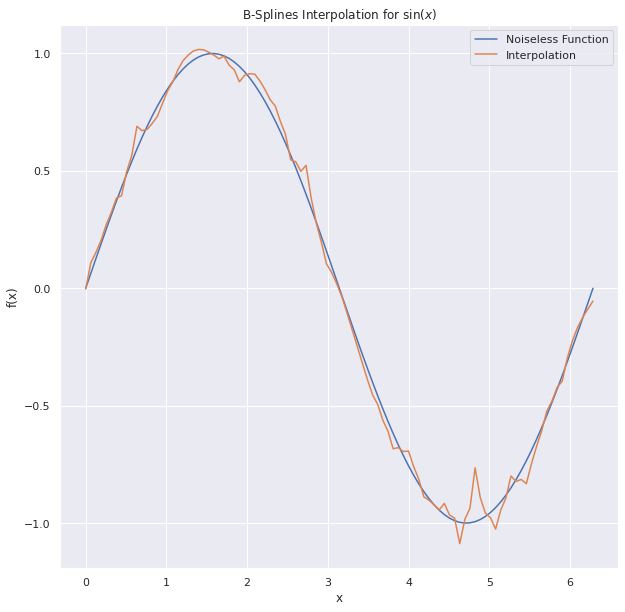

In [116]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(t_vec, f1(t, noisy=False))
ax.plot(t_vec, [bEval(t, c, x) for t in t_vec])

ax.set_title(r'B-Splines Interpolation for $\sin(x)$')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend(['Noiseless Function', 'Interpolation']);

In [125]:
n = 20 #Number of subintervals
t_vec = np.linspace(0,1,100) #Plotting interval

#First get our spline
c, x = leastSplines(0,1,n,f2)

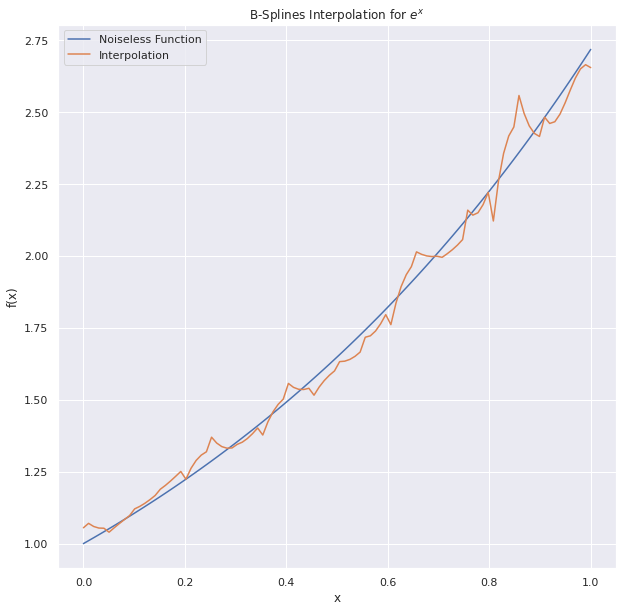

In [129]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(t_vec, f2(t_vec, noisy=False))
ax.plot(t_vec, [bEval(t, c, x) for t in t_vec])

ax.set_title(r'B-Splines Interpolation for $e^x$')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend(['Noiseless Function', 'Interpolation']);

In [130]:
n = 30 #Number of subintervals
t_vec = np.linspace(-2,2,100) #Plotting interval

#First get our spline
c, x = leastSplines(-2,2,n,f3)

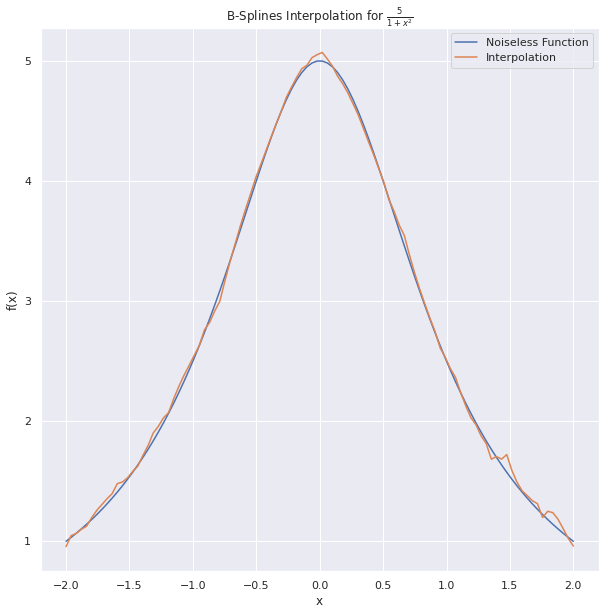

In [131]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(t_vec, f3(t_vec, noisy=False))
ax.plot(t_vec, [bEval(t, c, x) for t in t_vec])

ax.set_title(r'B-Splines Interpolation for $\frac{5}{1+x^2}$')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend(['Noiseless Function', 'Interpolation']);

In all of the plots above we see that our function does a pretty good job of interpolating the function. We note that we have used different numbers of subintervals depending on the problem. In fact, the number of subintervals can have substantial effect on the accuracy (although this is not necessarily shown here), and it doesn't always follow that more is better. Throughout the plots we notice that we get this somewhat jagged interpolation. This is an interesting phenomenon and an explanation is not readily apparent.

## c).
We will examine a spy plot of the matrix $\mathbf{A}$ and $\mathbf{A^TA}$ created in the B-splines process. We will look at this specifically for the $\sin(x)$ case given above.

In [132]:
n = 10 #Number of subintervals
t_vec = np.linspace(0,2*np.pi,100) #Plotting interval

#First get our spline
_, _, A = leastSplines(0,2*np.pi,n,f1, retA=True)

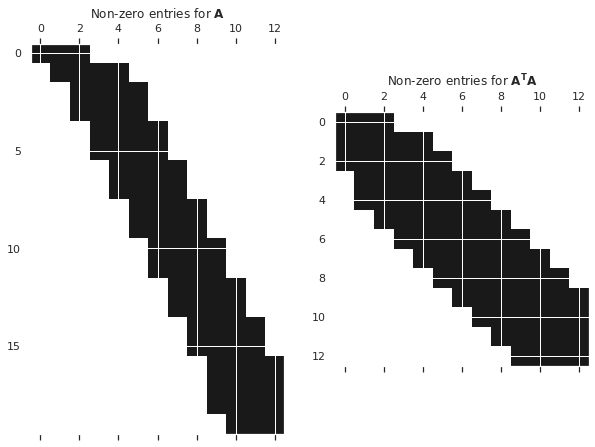

In [138]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].spy(A)
ax[1].spy(A.T@A)

ax[0].set_title(r'Non-zero entries for $\mathbf{A}$')
ax[1].set_title(r'Non-zero entries for $\mathbf{A^TA}$');

We see two spy plots above which show (in black) the non-zero entries of the matrix being plotted. With this we can note that our matrix $\mathbf{A}$ created in the B-splines processs is quite sparse and has a banded structure.